# Index - Human Rights

### 1) Importing the required packages

In [2]:
%run ./functions.ipynb

import pandas as pd
import numpy as np 
import pandas_datareader
from pandas_datareader import wb
from fancyimpute import KNN, SoftImpute, IterativeImputer, BiScaler, NuclearNormMinimization, IterativeSVD  
from sklearn import preprocessing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pmdarima as pm
import typing
import random
random.seed(2020)

### 2) Download the data

In [3]:
area = "Human_rights" #set the indicator area
area2 = "Human Rights" 

worldbank_data, tickers = load_the_database(area = area)

C:\Users\Bebezi\Anaconda3\lib\site-packages\pandas_datareader\wb.py:659: UserWarning:

No results found from world bank. Indicator: SG.LEG.SXHR

C:\Users\Bebezi\Anaconda3\lib\site-packages\pandas_datareader\wb.py:659: UserWarning:

No results found from world bank. Indicator: SG.LEG.MRRP



### 3) Area-specific data transformation

In [4]:
tickers_ = tickers[["Indicator ticker", "Transformation 1", "Transformation 2", "Scaling / Normalisation", "bounds", "symmetric value"]]

#inverse
inverse = tickers[tickers["Transformation 2"] == "inverse"]
inv = worldbank_data.columns[worldbank_data.columns.isin(inverse["Indicator ticker"])]
#worldbank_data[inv] = 1/(worldbank_data[inv] +0.02)
#worldbank_data[inv][worldbank_data > 50] = 50

worldbank_data[inv] = -worldbank_data[inv]


#bounded percentile
bounds_percentile = tickers[tickers["Scaling / Normalisation"] == "bounds_percentile"]
bounds = worldbank_data.columns[worldbank_data.columns.isin(bounds_percentile["Indicator ticker"])]

for col in bounds:
    percentiles = worldbank_data[col].groupby(level = 1).quantile([0.02,0.98]).values
    worldbank_data[col] = np.clip(worldbank_data[col], percentiles[0], percentiles[1])
    
#symmetric

symmetric = tickers[tickers["Scaling / Normalisation"] == "symmetric"]
sym = worldbank_data.columns[worldbank_data.columns.isin(symmetric["Indicator ticker"])]
worldbank_data[sym] = -(1 - worldbank_data[sym]).abs()

## Check the correlations

In [5]:
import seaborn as sb

corr_matrix = worldbank_data.corr()


#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
               
sol[sol <0.80]

SH.STA.FGMS.ZS  SG.LAW.CHMR       0.721529
SG.LAW.NODC.HR  SG.LAW.EQRM.WK    0.396383
SG.MMR.LEVE.EP  SG.LAW.NODC.HR    0.350005
SH.STA.FGMS.ZS  SG.LAW.EQRM.WK    0.344629
                SG.LEG.DVAW       0.342062
SG.VAW.1549.ZS  SG.LAW.EQRM.WK    0.278031
SG.MMR.LEVE.EP  SG.LAW.EQRM.WK    0.272331
SG.LEG.DVAW     SG.LAW.CHMR       0.271493
SG.VAW.1549.ZS  SG.LEG.DVAW       0.259200
                SG.MMR.LEVE.EP    0.231379
SG.LEG.DVAW     SG.LAW.NODC.HR    0.159008
SG.LAW.CHMR     SG.LAW.NODC.HR    0.155285
SG.MMR.LEVE.EP  SG.LAW.CHMR       0.122162
SG.VAW.1549.ZS  SG.LAW.NODC.HR    0.116952
SH.STA.FGMS.ZS  SG.MMR.LEVE.EP    0.088993
SG.LAW.CHMR     SG.LAW.EQRM.WK    0.083536
SG.LEG.DVAW     SG.LAW.EQRM.WK    0.072345
SG.LAW.CHMR     SG.LAW.LEVE.PU    0.045391
SH.STA.FGMS.ZS  SG.LAW.NODC.HR    0.031354
SG.MMR.LEVE.EP  SG.LAW.LEVE.PU    0.017938
                SG.LEG.DVAW      -0.007555
SG.LAW.LEVE.PU  SG.LAW.EQRM.WK   -0.043035
                SG.LAW.NODC.HR   -0.080035
SG.LEG.DVAW

In [7]:
worldbank_data_idx = worldbank_data.copy().reset_index()
worldbank_data_idx.replace([np.inf, -np.inf], np.nan, inplace = True)


### 4) Imputing the missing data


In [8]:
worldbank_data_filled = impute_missing()

### 5) Scaling and forecasting the data

In [9]:
worldbank_data_scaled = scale_and_forecast()

worldbank_data_scaled = worldbank_data_scaled.reset_index()
worldbank_data_scaled = worldbank_data_scaled.drop_duplicates(subset=['country', 'year'], keep='last')
worldbank_data_scaled.set_index(["country", "year"], inplace =True )
worldbank_data_scaled = worldbank_data_scaled.where(worldbank_data_scaled < 1, 1)

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. C

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

### 6) Build the index (mean, median, pca...)

In [10]:
#Taking the mean to build our indicator
worldbank_data_scaled["indicator"] = worldbank_data_scaled.mean(axis=1)

#IC1_ = IC1.set_index(["country", "year"])
#IC2_ = IC2.set_index(["country", "year"])

#IC1_["ic1"] = IC1_.mean(axis = 1)
#IC1_ = IC1_[["ic1"]]

#IC2_["ic2"] = IC2_.mean(axis = 1)
#IC2_ = IC2_[["ic2"]]


#worldbank_data_scaled_IC = worldbank_data_scaled.join(IC1_)
#worldbank_data_scaled_IC = worldbank_data_scaled_IC.join(IC2_)

#Or Median
#worldbank_data_scaled["indicator"] = worldbank_data_scaled.median(axis=1)

#Or it can be done by using PCA 

#from sklearn.decomposition import PCA
#pca = PCA(n_components = "mle")
#pca_fit = pca.fit_transform(worldbank_data_scaled)
#expvar = pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_) < 0.90001]
#leng = len(expvar)
#pca_fit = pd.DataFrame(pca_fit).iloc[:, : leng]
#pca_fit = -pca_fit
#pca_fit = pca_fit*expvar
#indicator = pca_fit.sum(axis = 1)
#indicator = (indicator - indicator.min(axis=0)) / (indicator.max(axis=0) - indicator.min(axis=0))
#
#worldbank_data_scaled.reset_index(inplace = True)
#worldbank_data_scaled["indicator"] = indicator





worldbank_data_scaled.reset_index(inplace = True)
worldbank_data_scaled.year = worldbank_data_scaled.year.astype(int)
merged_data = worldbank_data_scaled
std = pd.DataFrame(merged_data.groupby('country')["indicator"].std())
std = std.rename({'indicator': 'std'}, axis = "columns")
merged_data = pd.merge(merged_data, std, on = "country")
merged_data["ic1"] = (merged_data["indicator"] - merged_data["std"]) - (merged_data["year"]-2019)/100
merged_data["ic2"] =  (merged_data["indicator"] + merged_data["std"]) + (merged_data["year"]-2019)/100
merged_data["ic1"] = np.where(merged_data["year"] > 2019, merged_data["ic1"], "")
merged_data["ic2"] = np.where(merged_data["year"] > 2019, merged_data["ic2"], "")
merged_data[merged_data["year"] == 2019].nlargest(10, 'indicator')

,country,year,SH.STA.FGMS.ZS,SG.VAW.1549.ZS,SG.MMR.LEVE.EP,SG.LEG.DVAW,SG.LAW.CHMR,SG.LAW.LEVE.PU,SG.LAW.NODC.HR,SG.LAW.EQRM.WK,indicator,std,ic1,ic2
5355,Sweden,2019,0.814927,0.860255,0.977978,0.988413,0.979906,0.119677,0.962963,0.863581,0.820962,0.076688,,
2030,United Kingdom,2019,0.814927,0.860255,0.977978,0.988413,0.979906,0.119677,0.962963,0.863581,0.820962,0.076688,,
4760,Romania,2019,0.818669,0.838671,0.980161,0.991833,0.980173,0.124524,0.968547,0.861268,0.820481,0.075420,,
595,Bosnia and Herzegovina,2019,0.811800,0.861862,0.978747,0.989084,0.982784,0.104077,0.965966,0.865253,0.819947,0.077130,,
140,Argentina,2019,0.811800,0.861862,0.978747,0.989084,0.982784,0.104077,0.965966,0.865253,0.819947,0.077130,,
490,Bulgaria,2019,0.827846,0.794151,0.983982,0.997046,0.980749,0.130505,0.980234,0.857817,0.819041,0.069077,,
1400,Cyprus,2019,0.809809,0.894381,0.976106,0.986360,0.980162,0.126780,0.834712,0.869928,0.809780,0.076195,,
3815,Malta,2019,0.814522,0.871130,0.976404,0.987557,0.979855,0.130095,0.829834,0.868938,0.807292,0.072793,,
3325,St. Lucia,2019,0.816934,0.859039,0.977558,0.989672,0.979962,0.132950,0.830404,0.871322,0.807230,0.069897,,
2450,Croatia,2019,0.805256,0.893646,0.974832,0.986214,0.979454,0.111843,0.823046,0.866867,0.805145,0.078100,,


In [11]:
merged_data[merged_data["year"] == 2019].nlargest(10, 'indicator')[["country", "indicator"]]

,country,indicator
5355,Sweden,0.820962
2030,United Kingdom,0.820962
4760,Romania,0.820481
595,Bosnia and Herzegovina,0.819947
140,Argentina,0.819947
490,Bulgaria,0.819041
1400,Cyprus,0.809780
3815,Malta,0.807292
3325,St. Lucia,0.807230
2450,Croatia,0.805145


In [12]:
merged_data[merged_data["year"] == 2019]["indicator"]

0       0.508959
35      0.583494
70      0.624997
105     0.317078
140     0.819947
          ...   
6230    0.443543
6265    0.310449
6300    0.522439
6335    0.539663
6370    0.566847
Name: indicator, Length: 183, dtype: float64

### 7) Plot the indicator for each country

In [13]:
plot_variable()

C:\Users\Bebezi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 8) Export to a Csv File

In [14]:
merged_data.to_csv(area + "_index.csv")

In [15]:
coucodes = pd.read_csv("coucodes.csv", sep = ";", encoding='cp1252')
merged_data = pd.merge(merged_data, coucodes, left_on = "country", right_on = "Country Name WB")
merged_data = merged_data[merged_data["year"] == 2019]
merged_data.set_index("ISO Code", inplace = True)


cm = plt.get_cmap('Greens')
num_colors = 9
values = np.asarray(merged_data["indicator"], dtype='float64')
bins = np.linspace(values.min(), values.max(), num_colors)
merged_data['bin'] = np.digitize(values, bins) - 1
scheme = [cm(i / num_colors) for i in range(num_colors)]

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

shapefile = 'ne_10m_admin_0_countries'
cols = ['country', 'ISO Code', "indicator"]


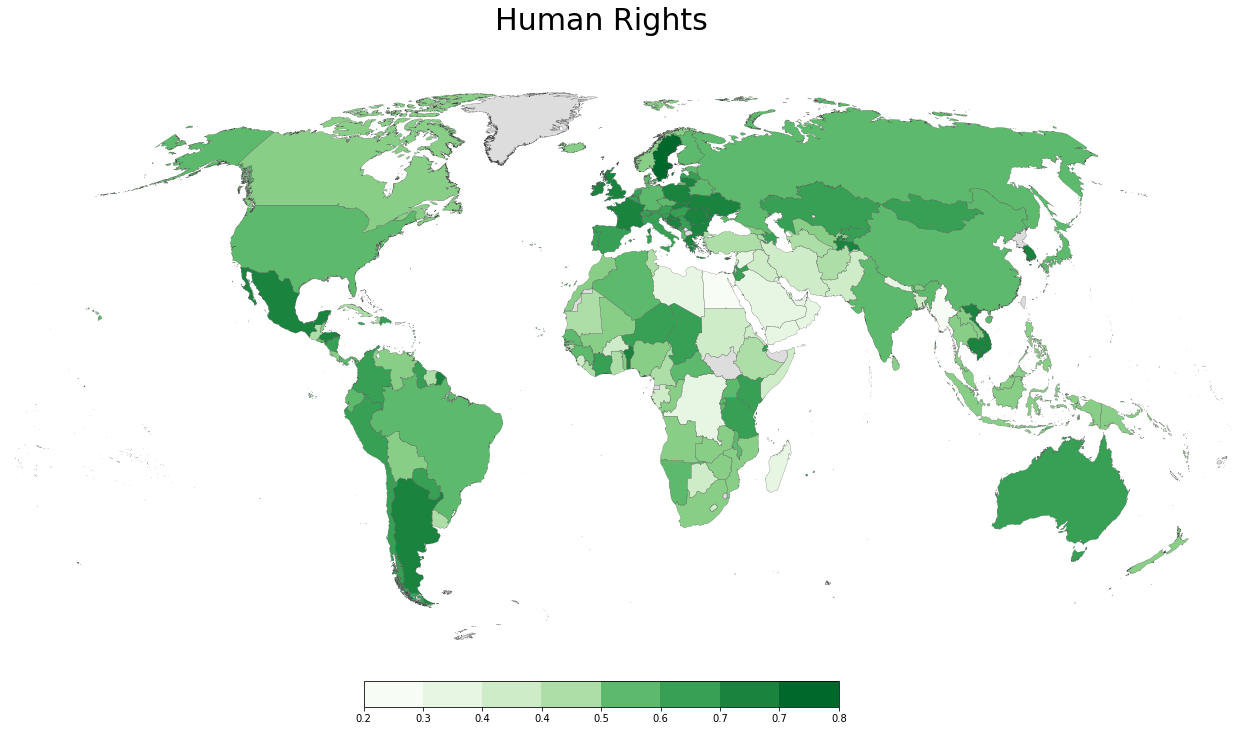

In [16]:
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.suptitle(area2, fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')

m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in merged_data.index:
        color = '#dddddd'
    else:
        color = scheme[merged_data.loc[iso3]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

# Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
#plt.annotate(description, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
plt.savefig('education_map.png')

